
## Simulation for Optimal Parameter Selection in the Risk Assessment Framework

This document presents a simulation conducted to determine the optimal values of 𝜇 and 𝛽 for the Risk Assessment (RA) framework. The objective of this simulation is to identify the parameter values that yield the most appropriate likelihood and impact probabilities within a predefined acceptable range, ensuring a balanced assessment of security risks in the network.

The simulation follows a structured methodology, outlined as follows:

### Defining the Expected Probability Ranges
Based on the established threat model and the assumption that any attack is possible under the defined network architecture, acceptable probability ranges for both the likelihood of occurrence and the impact of attacks were defined. These ranges serve as reference points for evaluating the computed probabilities.

### Computing the Probabilities
The defined attack set is considered alongside the unconditional probabilities derived from the CVSS v3.1 score metrics. Using the predefined equations for MF_LS (likelihood) and MI_LS (impact), the probabilities for each attack can be computed as follows:

    - 𝑃𝑀_𝐹 = 𝜇 × 𝑀𝐹_LS

    - 𝑃𝑀_𝐼 = 𝛽 × 𝑀𝐼_LS

    where 𝑃𝑀_𝐹  and  𝑃𝑀_𝐼 represent the adjusted probabilities based on the parameters 𝜇 and 𝛽 respectively.

### Evaluating Acceptable Probability Counts
The computed probability values are then compared against the predefined acceptable ranges from Step 1. A count is performed for each values of mu and beta, to determine the number of attacks for which the likelihood and impact probabilities fall within the acceptable ranges.

### Determining the Optimal Values for 𝜇 and 𝛽 
The optimal values for mu and beta are determined in two steps:

- All values of mu and beta yielding to a count of P_MF and P_MI above the 75th percentile of the distribution of P_MF and P_MI are considered
    
- The average value of the previously considered mu and beta are computed for the optimal mu and optimal beta respectively.

This ensures a more stable selection by including a broader set of well-performing values while avoiding over-reliance on a single peak value that might depend on the attack dataset. This method enhances the adaptability of the model to different network scenarios by providing a balanced and statistically meaningful parameter selection."

By following this methodology, the simulation ensures that the chosen parameters align with the expected security conditions, thereby enhancing the reliability of the Risk Assessment framework.

### Optimal Values for mu and beta

- The initial values of mu and beta vary from 0.05 to 1, with a step of 0.05
  - Note: mu and beta cannot be null, because a null value would nullify the likelihood or impact of the exploit of the vulnerability
  
- Based on the CVSS v3.1 score metrics and the defined threat model, an estimation of the expected values for MF and MI range from [0.45, 0.95] and [0.2, 0.9] respectively for the defined network architecture.


- The resulting optimal values for mu and beta are 0.8 and 0.75 respectively


- Details for determining the range for mu: (0.45, 0.95)
    - When considering the CVSS metrics Base exploitability metrics, as well as the lowest ratings and values for each metric (for a secure network); the base exploitability score is 0.425.
    - Given the expected net threat of 0.5 and the base exploitability of 0.425; the lower bound value for mu is 0.45, a value between 0.425 and 0.5
    - A higher bound of 0.95 reflects that some attacks may be highly probable, given the absence of robust security measures. However, it is not set at 1.0, since even in low-security environments, absolute certainty of an attack occurring is unrealistic.


- Details for determining the range for beta: (0.2, 0.9)
    - Given the CVSS base impact metrics, when considering an attack impact on a security measure, the impact can range from None (0) to Low (0.22) or High (0.56)
    - The lower bound is determined by considering that an attack will always have an impact on at least one security parameter if successful (for example, eavesdropping can have an impact of 0 (None) on the Integrity security metric, but Low (0.22) or High (0.56) on the Confidentiality, if successful.
    - The lower bound for the impact is therefore fixed at 0.2
    - The Higher bound (0.9) reflects the possibility of highly damaging attacks (e.g., complete network compromise or system failures) while excluding total system destruction (impact = 1.0).






In [95]:
import pandas as pd

# getting the unconditional probabilities of the attacks, without the values of mu or beta
df = pd.read_csv('mi_mf_attacks_computations_csv.csv', sep =';')

df['MF'] = df['MF_LS'].str.replace(',', '.').astype(float)
df['MI'] = df['MI_LS'].str.replace(',', '.').astype(float)

df.head(10)



,Attack number,pre-conditions,join type,Attack,MF_LS,MI_LS,MF,MI
0,0,NaN,NaN,Topology discovery,"0,905833333","0,685888889",0.905833,0.685889
1,1,NaN,NaN,limited authentication,"0,906111111","0,663888889",0.906111,0.663889
2,2,NaN,NaN,attacker in communication range,"0,856333333","0,529353333",0.856333,0.529353
3,3,NaN,NaN,user code executed,"0,852666667","0,529353333",0.852667,0.529353
4,4,"1, 25",OR,Node Subversion integrity,"0,858","0,665973333",0.858000,0.665973
5,5,2,OR,Jamming & DoS,"0,833333333","0,431777778",0.833333,0.431778
6,6,"40,2",AND,Packet sniffing/ eavesdropping,"0,826666667","0,431777778",0.826667,0.431778
7,7,"4,1",OR,Sybil attack,"0,858","0,408457778",0.858000,0.408458
8,8,"4,7",OR,Masquerading integrity,"0,8235","0,408457778",0.823500,0.408458
9,9,"4,7",AND,Spoofing/False entity,"0,8235","0,721528889",0.823500,0.721529


Best mu for MF (likelihood) in range 0.45-0.95: 0.8
Best beta for MI (impact) in range 0.2-0.9: 0.75


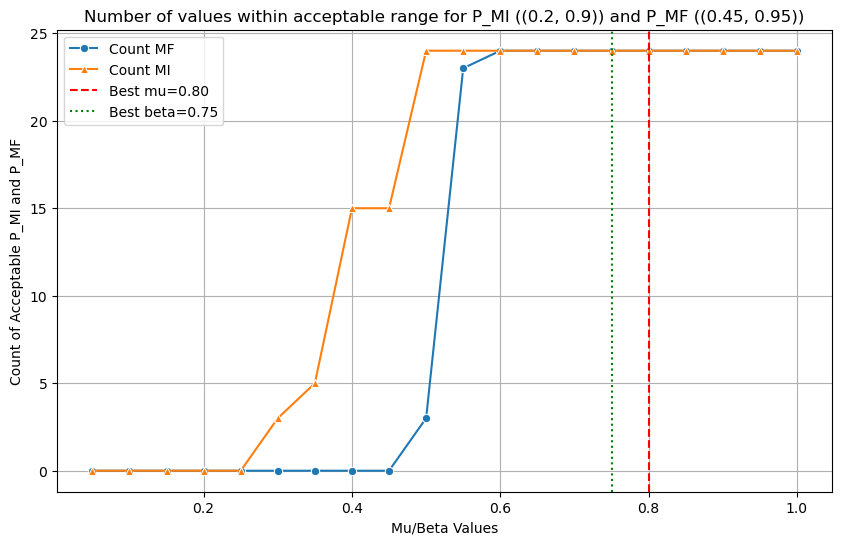

In [111]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


# Generate values of mu and beta with a step of 0.1
mu_values = np.arange(0.05, 1.05, 0.05)
beta_values = np.arange(0.05, 1.05, 0.05)

# Define separate acceptable likelihood and risk probability ranges
# Given the threat model, the objective here is to get mu and beta values that leads to probabilities of MF and MI between the acceptable ranges
# Note: the threat model assumes any attack can happen, with an average level of security
min_MF, max_MF = 0.45 , 0.95
min_MI, max_MI = 0.2, 0.9

# Store results separately for mu and beta
results_MF = []
results_MI = []

# Iterate through mu values (for MF)
for mu in mu_values:
    df["P_MF"] = mu * df["MF"]  # Probability from Likelihood

    # Count how many values fall within the acceptable range
    within_range_MF = ((df["P_MF"] >= min_MF) & (df["P_MF"] <= max_MF)).sum()

    # Store results
    results_MF.append({"mu": mu, "count_MF": within_range_MF})

# Iterate through beta values (for MI)
for beta in beta_values:
    df["P_MI"] = beta * df["MI"]  # Probability from Impact

    # Count how many values fall within the acceptable range
    within_range_MI = ((df["P_MI"] >= min_MI) & (df["P_MI"] <= max_MI)).sum()

    # Store results
    results_MI.append({"beta": beta, "count_MI": within_range_MI})

# Convert results to DataFrames
results_MF_df = pd.DataFrame(results_MF)
results_MI_df = pd.DataFrame(results_MI)

# Calculate the 75th percentile of count_MI
percentile_75_MI = results_MI_df['count_MI'].quantile(0.75)
percentile_75_MF = results_MF_df['count_MF'].quantile(0.75)

# Filter the DataFrame for count_MI values greater than the 75th percentile
filtered_df_MI = results_MI_df[results_MI_df['count_MI'] >= percentile_75_MI]
filtered_df_MF = results_MF_df[results_MF_df['count_MF'] >= percentile_75_MF]

# Calculate the mean of the beta values in the filtered DataFrame
best_mu = filtered_df_MF['mu'].mean()
best_beta = filtered_df_MI['beta'].mean()

# Find the best mu and beta separately
#best_mu = round( np.arange(round(results_MF_df.nlargest(1, "count_MF").iloc[0]["mu"], 3) , 1.01, 0.05).mean(), 3)
#best_beta = round( np.arange(round(results_MI_df.nlargest(1, "count_MI").iloc[0]["beta"], 3) , 1.01, 0.05).mean(), 3) 

print(f"Best mu for MF (likelihood) in range {min_MF}-{max_MF}: {best_mu}")
print(f"Best beta for MI (impact) in range {min_MI}-{max_MI}: {best_beta}")

#######

# Combined Visualization
plt.figure(figsize=(10, 6))

# Scatter plot for Count MF (using squares)
sns.lineplot(x="mu", y="count_MF", data=results_MF_df, marker="o", label="Count MF")

# Scatter plot for Count MI (using triangles)
sns.lineplot(x="beta", y="count_MI", data=results_MI_df, marker="^", label="Count MI")

# Vertical lines for best mu and beta
plt.axvline(best_mu, color="r", linestyle="--", label=f"Best mu={best_mu:.2f}")
plt.axvline(best_beta, color="g", linestyle=":", label=f"Best beta={best_beta:.2f}")

# Title and labels
plt.title(f"Number of values within acceptable range for P_MI ({min_MI, max_MI}) and P_MF ({min_MF, max_MF })")
plt.xlabel("Mu/Beta Values")
plt.ylabel("Count of Acceptable P_MI and P_MF")

# Legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



